## Working with Text
---
> 罗晨

> Nov, 2017

In [1]:
!python3 --version

Python 3.6.3


### DTM: Doc-term matrix
- 语料分析最常用的方法是建立词频 word frequencies （包含词频的列表）或者n-连词频 n-grams frequencies
- 文本作为向量（包含词频的列表），词袋（无序）

In [2]:
import numpy as np
'''
用scikit-learn中的CountVectorizer类来建立DTM
包含参数：
lowercase 分词前全部字母小写
min_df 移除少于在min_df文档中出现的词
vocabulary 设置这个后，会忽略不在vocabulary中的单词
strip_accents 移除accents
token_pattern 用re来设置是否保留某些字符
tokenizer 分词器
'''
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
filenames = ['data/austen-brontë/Austen_Emma.txt', 
             'data/austen-brontë/Austen_Pride.txt', 
             'data/austen-brontë/Austen_Sense.txt', 
             'data/austen-brontë/CBronte_Jane.txt', 
             'data/austen-brontë/CBronte_Professor.txt', 
             'data/austen-brontë/CBronte_Villette.txt']
vectorizer = CountVectorizer(input='filename')
# dtm是一个稀疏矩阵
# Python中一个整数占据4个字节
dtm = vectorizer.fit_transform(filenames)
# vocab是一个包含词汇的列表，词汇就是特征 features
vocab = vectorizer.get_feature_names()

In [4]:
# 都转化为NumPy array以适应更多操作
dtm = dtm.toarray()
vocab = np.array(vocab)
print(dtm.shape)
print(vocab.shape)

(6, 22854)
(22854,)


In [5]:
# 计算house在第一个文档出现的次数
# 方法1:基本方法
filenames[0] == 'data/austen-brontë/Austen_Emma.txt'
house_idx = list(vocab).index('house')
dtm[0, house_idx]

95

In [6]:
# 方法2:效果同上，但更推荐NumPy arrays的操作习惯
# NumPy中，X.dot(Y) = XY
dtm[0, vocab == 'house']

array([95], dtype=int64)

In [7]:
import os
import pandas as pd

In [8]:
queryDreq = {}
queryWord = ['and', 'emma', 'home', 'house', 'of', 'the']
for doc in range(len(filenames)):
    lst = []
    for word in queryWord:
        value = dtm[doc, vocab == word]
        lst.append(value[0])
    queryDreq[os.path.basename(filenames[doc]).split('.')[0]] = lst
queryDreq = pd.DataFrame(queryDreq)
queryDreq.index = queryWord
queryDreq

,Austen_Emma,Austen_Pride,Austen_Sense,CBronte_Jane,CBronte_Professor,CBronte_Villette
and,4896,3584,3491,6626,2936,6374
emma,865,0,0,0,0,0
home,130,66,69,80,37,121
house,95,107,161,182,93,129
of,4291,3609,3572,4364,2663,4845
the,5201,4330,4105,7846,3836,8363


### 比较文本
- DTM中每一行都是一本小说的词频，可以视为向量
- Euclidean Distance，可以扩展到多维空间中
$$||\vec{x} - \vec{y}|| = \sqrt{\sum_{i=1}^p (x_i - y_i)^2}$$

In [9]:
# 手工计算行数、列数
n, _ = dtm.shape
print(n, _)

6 22854


In [10]:
# 建立一个6*6，数值全部为0的矩阵
dist = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        x, y = dtm[i, :], dtm[j, :]
        dist[i, j] = np.sqrt(np.sum((x - y) ** 2))
dist

array([[    0.        ,  3856.28875993,  4182.80109496,  5119.70301873,
         7113.27378919,  5280.17244037],
       [ 3856.28875993,     0.        ,  1922.60500363,  6313.08339878,
         4126.23932898,  6381.23875121],
       [ 4182.80109496,  1922.60500363,     0.        ,  6657.36419313,
         4045.34460831,  6650.31202276],
       [ 5119.70301873,  6313.08339878,  6657.36419313,     0.        ,
         8363.82765246,  2591.54664245],
       [ 7113.27378919,  4126.23932898,  4045.34460831,  8363.82765246,
            0.        ,  8484.05557502],
       [ 5280.17244037,  6381.23875121,  6650.31202276,  2591.54664245,
         8484.05557502,     0.        ]])

In [11]:
from sklearn.metrics.pairwise import euclidean_distances

In [12]:
dist = euclidean_distances(dtm)
# round可以设置保留几位小数
np.round(dist, 2)

array([[    0.  ,  3856.29,  4182.8 ,  5119.7 ,  7113.27,  5280.17],
       [ 3856.29,     0.  ,  1922.61,  6313.08,  4126.24,  6381.24],
       [ 4182.8 ,  1922.61,     0.  ,  6657.36,  4045.34,  6650.31],
       [ 5119.7 ,  6313.08,  6657.36,     0.  ,  8363.83,  2591.55],
       [ 7113.27,  4126.24,  4045.34,  8363.83,     0.  ,  8484.06],
       [ 5280.17,  6381.24,  6650.31,  2591.55,  8484.06,     0.  ]])

In [13]:
# filenames[1] == 'data/austen-brontë/Austen_Pride.txt'
# filenames[3] == 'data/austen-brontë/CBronte_Jane.txt'
# dist[1, 3] == dist[3, 1]
dist[1, 3]

6313.0833987838305

In [14]:
print(filenames[5])
dist[1, 3] > dist[3, 5]

data/austen-brontë/CBronte_Villette.txt


True

- 余弦相似性 cosine similarity，返回0-1之间的值，计算基础是两个向量之间的夹角
    - 优点：能够考虑到文本长度

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
dist = 1 - cosine_similarity(dtm)
np.round(dist, 2)

array([[ 0.  ,  0.02,  0.03,  0.05,  0.06,  0.05],
       [ 0.02,  0.  ,  0.02,  0.05,  0.04,  0.04],
       [ 0.03,  0.02, -0.  ,  0.06,  0.05,  0.05],
       [ 0.05,  0.05,  0.06,  0.  ,  0.02,  0.01],
       [ 0.06,  0.04,  0.05,  0.02,  0.  ,  0.01],
       [ 0.05,  0.04,  0.05,  0.01,  0.01,  0.  ]])

In [17]:
dist[1, 3]

0.047026234323164884

In [18]:
dist[1, 3] > dist[3, 5]

True

In [19]:
# 手动计算，相当于调用包sklearn.metrics.pairwise.cosine_similarity之后的原理
norms = np.sqrt(np.sum(dtm * dtm, axis = 1, keepdims = True))
dtm_normed = dtm / norms
# np.dot就是执行矩阵乘法
similarities = np.dot(dtm_normed, dtm_normed.T)
1 - np.round(similarities, 2)

array([[ 0.  ,  0.02,  0.03,  0.05,  0.06,  0.05],
       [ 0.02,  0.  ,  0.02,  0.05,  0.04,  0.04],
       [ 0.03,  0.02,  0.  ,  0.06,  0.05,  0.05],
       [ 0.05,  0.05,  0.06,  0.  ,  0.02,  0.01],
       [ 0.06,  0.04,  0.05,  0.02,  0.  ,  0.01],
       [ 0.05,  0.04,  0.05,  0.01,  0.01,  0.  ]])

In [20]:
similarities[1, 3]

0.95297376567683512

In [21]:
print(dist[1, 3] + similarities[1, 3])
print(dist[2, 3] + similarities[2, 3])

1.0
1.0


### 距离可视化
- 在平面上描绘点（一个点代表一个文本），保证点之间的距离与计算的距离成比例
- 多维尺度 Multidimensional Sacling（MDS）

In [22]:
import os
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = 15, 15
from sklearn.manifold import MDS

In [23]:
'''
n_components 在n维空间绘制
distance similarity: precomputed 因为我们已经计算出距离矩阵
random_state 保证图表可复制，类似于seed
'''
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(dist)

In [24]:
xs, ys = pos[:, 0], pos[:, 1] # 坐标点
names = [os.path.basename(fn).replace('.txt', '') for fn in filenames]
print(names)

['Austen_Emma', 'Austen_Pride', 'Austen_Sense', 'CBronte_Jane', 'CBronte_Professor', 'CBronte_Villette']


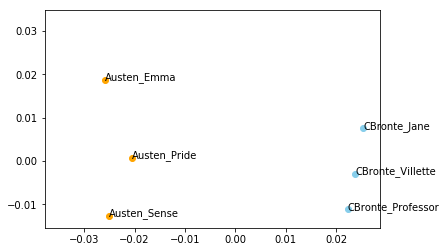

In [25]:
for x, y, name in zip(xs, ys, names):
    color = 'orange' if 'Austen' in name else 'skyblue'
    plt.scatter(x, y, c = color)
    plt.text(x, y, name)
plt.show()

In [26]:
# 将距离示意图绘制在三维空间
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(dist)

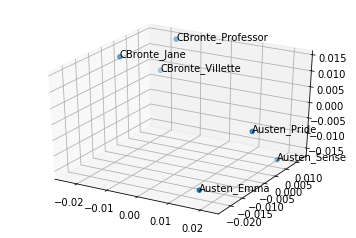

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], names):
    ax.text(x, y, z, s)
plt.show()

### 执行文本聚类：基于距离
- distances to clusters：距离相近的归为一类
- 基于距离聚类有多重计算方法
- 方法：Ward's method，产生聚类层级
    1. 每个文本都自成一类
    2. 找到最近的类然后聚合，类与类的距离在不断改变，直接最后只有一个类保留下来
    3. 绘制出树状图，显示类聚合的记录

In [28]:
from scipy.cluster.hierarchy import ward, dendrogram # dendrogram：系统树图

In [29]:
linkage_matrix = ward(dist)

In [30]:
dendrogram(linkage_matrix, orientation='left', labels = names)

{'color_list': ['g', 'g', 'r', 'r', 'b'],
 'dcoord': [[0.0, 0.016230837530887207, 0.016230837530887207, 0.0],
  [0.0, 0.025545848899507794, 0.025545848899507794, 0.016230837530887207],
  [0.0, 0.026664938674017275, 0.026664938674017275, 0.0],
  [0.0, 0.039973173157400656, 0.039973173157400656, 0.026664938674017275],
  [0.025545848899507794,
   0.16535482370283791,
   0.16535482370283791,
   0.039973173157400656]],
 'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5]],
 'ivl': ['CBronte_Jane',
  'CBronte_Professor',
  'CBronte_Villette',
  'Austen_Emma',
  'Austen_Pride',
  'Austen_Sense'],
 'leaves': [3, 4, 5, 0, 1, 2]}

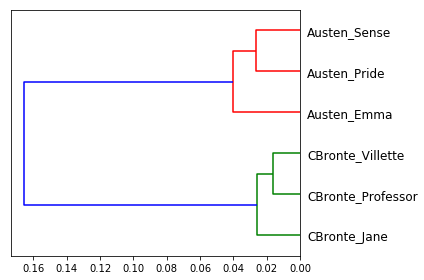

In [31]:
plt.tight_layout()
plt.show()

### 练习

- Find two different ways of determining the number of times the word ‘situation’ appears in Emma. (Make sure the methods produce the same result.)

In [32]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
filename = ['data/austen-brontë/Austen_Emma.txt']
vectorizer = CountVectorizer(input = 'filename')
dtm = vectorizer.fit_transform(filename)
vocab = vectorizer.get_feature_names()
dtm = dtm.toarray()
vocab = np.array(vocab)
print(dtm.shape)
print(vocab.shape)

(1, 7237)
(7237,)


In [34]:
# Way 1
dtm[0, list(vocab).index('situation')]

64

In [35]:
# Way 2
dtm[0, vocab == 'situation']

array([64], dtype=int64)

- Working with the strings below as documents and using `CountVectorizer` with the `input='content'` parameter, create a document-term matrix. Apart from the `input` parameter, use the default settings.

In [36]:
text1 = "Indeed, she had a rather kindly disposition."
text2 = "The real evils, indeed, of Emma's situation were the power of having rather too much her own way, \
and a disposition to think a little too well of herself;"
text3 = "The Jaccard distance is a way of measuring the distance from one set to another set."

In [37]:
contents = [text1, text2, text3]
# 注意：input不再是filename而是content
vectorizer = CountVectorizer(input = 'content')
dtm = vectorizer.fit_transform(contents)
vocab = vectorizer.get_feature_names()
dtm = dtm.toarray()
vocab = np.array(vocab)
print(dtm.shape)
print(vocab.shape)

(3, 34)
(34,)


In [38]:
type(dtm)

numpy.ndarray

In [39]:
dtm

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 3, 0, 1, 1,
        1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1],
       [0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0]], dtype=int64)

In [40]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(dtm)
np.round(dist, 2)

array([[ 0.  ,  6.08,  5.2 ],
       [ 6.08,  0.  ,  6.32],
       [ 5.2 ,  6.32,  0.  ]])

In [41]:
dist[1, 2] > dist[0, 1]

True

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(dtm)
np.round(dist, 2)

array([[ 1.  ,  0.2 ,  0.  ],
       [ 0.2 ,  1.  ,  0.32],
       [ 0.  ,  0.32,  1.  ]])

In [43]:
dist[1, 2] > dist[0, 1]

True

- Using the document-term matrix just created, calculate the Euclidean distance, Jaccard distance, and cosine distance between each pair of documents. Make sure to calculate distance (rather than similarity). Are our intuitions about which texts are most similar reflected in the measurements of distance?

### 距离计算
- Ward：用于系统聚类中，借助最小方差原则，一个类中的方差是最小的
- Jaccard：通过集合之间的交集关系来计算相似性